In [1]:
##### NEEDED EXECUTION FOR GOOGLE COLAB #####

# #on importe notre google drive sur le serveur distant de Google 
# from google.colab import drive
# drive.mount('/gdrive')

# #penser à faire les importation de package qui ne sont pas nativement present sur le serveur 
# !pip install ray[tune]

# #save des resultats : attention à ne pas les sauvegarder seulement sur le serveur Google, mais à les sauvegarder dans notre drive.
# drivefolder = ""

# #notre terminal pour se deplacer sur le serveur distant 
# %cd digit-recognizer
# !ls

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data_train, data_val = train_test_split(data ,test_size=0.1, random_state=10, shuffle=True)


In [3]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

###################################################################################
'''
Pour la prochaine fois : manière assez clair de transformer les rawdata, séparer x et y et tout convertir en torch dès le init. 
Et dans le len / getitem on met presque rien, sauf la fontion transform de pytorch
 '''

class MNISTDataset(Dataset):
    def __init__(self, data,transform=None, is_test=False):
        super().__init__()
        self.dataset = data
        self.transform=transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data = self.dataset.iloc[index].to_numpy()
        if self.is_test:
            label = None                            #il faut dire ce qui est le Y et ce qui est le X pour chaque ligne 
            image = data.reshape(28, 28)
        else:
            label = data[0]                             #il faut dire ce qui est le Y et ce qui est le X pour chaque ligne 
            image = data[1:].reshape(28, 28)
        if self.transform is not None:
            image = self.transform(image.astype(np.float32))
        return image, label
        
transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])

In [4]:
#on crée une classe enfant de la classe Dataset de torch, qui permet de convertir en tenseur
Tdata_train = MNISTDataset(data_train, transform= transform)
Tdata_val = MNISTDataset(data_val,  transform= transform)
Tdata_test = MNISTDataset(data_test, transform= transform, is_test=True)

#important que le label soit un tenseur ou pas ? 
Tdata_train[0][1]

3

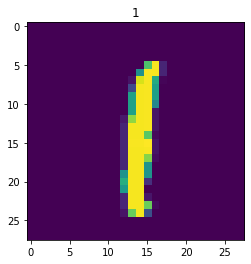

In [5]:
#affichage d'une image au hasard et du label associé
import matplotlib.pyplot as plt
i = np.random.randint(0, len(Tdata_train))
plt.imshow(Tdata_train[i][0].reshape(28,28))
plt.title(Tdata_train[i][1])
plt.show()

In [6]:
#mise en forme de batches des données (DataLoader)
torch.manual_seed(1)
batch_size= 16
DL_train = DataLoader(Tdata_train,batch_size,shuffle=True)
DL_val = DataLoader(Tdata_val,batch_size,shuffle=True)

In [7]:
# et sans utiliser le DataLoader ça donne quoi ? (à faire pour mieux comprendre)

## 1/ CNN model

### a/ Construction

In [41]:
from torch import nn
from torch.nn import functional as F
from torch import optim

#construction d'un CNN paramétrable 
class MyCNN(nn.Module):
    def __init__(self,pooling = nn.MaxPool2d, conv = nn.Conv2d, kernel1 = 5, kernel2 = 5, nb_channel1 = 16, nb_channel2 = 16):
        super().__init__()
        self.image_size = 28

        self.conv1 = conv(in_channels=1, out_channels= nb_channel1, kernel_size = kernel1)
        self.image_size = self.image_size - (self.conv1.kernel_size[0] - 1)

        self.pool1 = pooling(kernel_size = 3, stride = 1)
        self.image_size = self.image_size - (self.pool1.kernel_size - 1)
        
        self.conv2 = conv(in_channels=16, out_channels= nb_channel2, kernel_size = kernel2)
        self.image_size = self.image_size - (self.conv2.kernel_size[0] - 1)

        self.pool2 = pooling(kernel_size = 3, stride = 1)
        self.image_size = self.image_size - (self.pool2.kernel_size - 1)
       
        '''
        comment faire pour recuperer la taille de l'output après un certain modèle ?
        plutot que de calculer avec les formules ... 
        '''

        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)

        self.input_classifier = nb_channel2*self.image_size**2
        self.lin1 = nn.Linear(self.input_classifier,120)
        self.lin2 = nn.Linear(120, 10)
        
        self.features   = nn.Sequential(self.conv1,nn.ReLU(),self.pool1,self.conv2,nn.ReLU(),self.pool2)
        self.classifier = nn.Sequential(self.lin1,nn.ReLU(),self.lin2)
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x.view(x.size(0), -1))
        return x



### b/ Training

In [52]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

def accuracy(yhat,y):
    # y encode les indexes, s'assurer de la bonne taille de tenseur
    assert len(y.shape)==1 or y.size(1)==1
    return (torch.argmax(yhat,1).view(y.size(0),-1)== y.view(-1,1)).double().mean()
    

"""TO DOOOOOO"""
#paramétrer l'optimiseur, la loss, la taille de batch, 
# rajouter un stop si la loss en validation augmente...patience et early stopping
def train(model,epochs,train_loader,test_loader, writer = None, device = 'cpu', lr = 1e-3): 
    optim = torch.optim.Adam(model.parameters(),lr = lr)    # choix optimizer
    model = model.to(device)
    print(f"running {model.name}")
    loss = nn.CrossEntropyLoss()                            # choix loss
    
    for epoch in tqdm(range(epochs)):
        cumloss, cumacc, count = 0, 0, 0
        model.train()
        for x,y in train_loader:                           # boucle sur les batchs  
            optim.zero_grad()
            x,y = x.to(device), y.to(device)                # y doit être un tensor (pas un int)
            yhat = model(x)
            l = loss(yhat,y)
            l.backward()
            optim.step()
            cumloss += l*len(x)                             # attention, il peut y avoir un batch + petit (le dernier)
            cumacc += accuracy(yhat,y)*len(x)
            count += len(x)
        if writer != None:
            writer.add_scalar('loss/train',cumloss/count,epoch)
            writer.add_scalar('accuracy/train',cumacc/count,epoch)
            print(cumloss/count)
        
        if epoch % 1 == 0:
            model.eval()
            with torch.no_grad():
                cumloss, cumacc, count = 0, 0, 0
                for x,y in test_loader:
                    x,y = x.to(device), y.to(device)
                    yhat = model(x)
                    cumloss += loss(yhat,y)*len(x)
                    cumacc += accuracy(yhat,y)*len(x)
                    count += len(x)
                if writer != None:
                    writer.add_scalar(f'loss/test',cumloss/count,epoch)
                    writer.add_scalar('accuracy/test',cumacc/count,epoch)
                print('                ' + str(cumloss/count))

In [53]:
def model_test(model,Data_eval, device = 'cpu'):
    true_pred = 0
    tot_pred = 0
    model.eval()
    with torch.no_grad():
        for x,y in Data_eval:
            x,y = x.to(device), y.to(device)
            tot_pred += 1
            yhat = model(x).argmax(1)
            if yhat == y:
                true_pred += 1
    return true_pred / tot_pred*100

### c/ Run and save a model

In [33]:
import os

def save_model(model,fichier): # pas de sauvegarde de l'optimiseur ici
      """ sauvegarde du modèle dans fichier """
      state = {'model_state': model.state_dict()}
      torch.save(state,fichier) # pas besoin de passer par pickle
 
def load_model(fichier,model):
      """ Si le fichier existe, on charge le modèle  """
      if os.path.isfile(fichier):
            state = torch.load(fichier)
            model.load_state_dict(state['model_state'])

In [1]:
### entraineemnt long des modèle en DL, il faut privilégier de charger un modèle (puis fine-tuning)
import time 

device = 'cpu'
model = MyCNN().to(device)
model.name="1stConv-"+time.asctime() 
'''attention il faut que le nom du fichier contienne toutes les infos sur les hyperparamètres utilisés dans le modèle, 
pour pouvoir le recharger ensuite (ou bien sauvegardé en plus un fichier de la configuration du modèle utilisé'''
#writer = SummaryWriter(f"runs/")
epochs = 20
train(model, epochs, DL_train, DL_val)
file = model.name
save_model(model,'models/' + file)

NameError: name 'MyCNN' is not defined

### d/ Comparaison de modèles et optimisation

* optimisation des pretraitements // features engineering
* On effectue un GridSearch des hyperparamètres de notre modèle
* On optimise l'accuracy avec un grand nombre d'initialisation de poids différents
* Utilisation de méthodes d'ensemble
* Evolution de l'architecture du modèle

Pas réussi à utiliser correctement raytune...
______________________________________________________________________________________________________________________________


In [10]:
#USE OF RAY TUNE for the gridsearch of hyperparameters
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

In [11]:
# on a besoin de redefinir une fonction de train qui va etre appelée par tune.run
# la fonction doit incorporer l'initialisation du modèle avec les hyperparamètres données par le config, 
# en plus de l'entrainement du modèle

#on incorpore dans la fonction de train un paramètre config qui contient les hyperparamètres
def ray_train(config, trainloader, valloader, checkpoint_dir=None, epochs = 10):

    #init le reseau et les paramètres d'optimisations
    net = MyCNN(config["kernel1"], config["kernel2"])
    loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)


    #choose device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)


    #load checkpoint
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    ###### optimization des poids du réseau (boucle d'entraineemnt avec incorporation de tune #########
    print(f"running {net.name}")
    for epoch in tqdm(range(epochs)):
        cumloss, cumacc, count = 0, 0, 0
        net.train()
        for x,y in trainloader:                           # boucle sur les batchs  
            optimizer.zero_grad()
            x,y = x.to(device), y.to(device)                # y doit être un tensor (pas un int)
            yhat = net(x)
            l = loss(yhat,y)
            l.backward()
            optimizer.step()
            cumloss += l*len(x)                             # attention, il peut y avoir un batch + petit (le dernier)
            cumacc += accuracy(yhat,y)*len(x)
            count += len(x)
        
        cumloss, cumacc, count = 0, 0, 0
        if epoch % 1 == 0:
            net.eval()
            with torch.no_grad():
                
                for x,y in valloader:
                    x,y = x.to(device), y.to(device)
                    yhat = net(x)
                    cumloss += loss(yhat,y)*len(x)
                    cumacc += accuracy(yhat,y)*len(x)
                    count += len(x)

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(cumloss / count), accuracy = cumacc)
    print("Finished Training") 
  


In [ ]:
#lancement de ray.tune pour la recherche des hyperparamètres
max_num_epochs = 5
gpus_per_trial = 0
num_samples = 2

# on definit les parametres à    optimiser
config = {
        "kernel1" : tune.choice([3, 5, 9]), 
        "kernel2" : tune.choice([3, 5, 9]),
        "lr": tune.loguniform(1e-4, 1e-1),
        # "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        # "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        # "batch_size": tune.choice([2, 4, 8, 16])
    }

#definit un scheduler qui interrompera les entrainements qui ne progressent pas
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2)

#definit un reporter qui affiche les resultats
reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "accuracy", "training_iteration"])


#entrainement du réseau en passant par raytune, on peut préciser les ressources utilisées pour chaque entrainement
result = tune.run(
    partial(ray_train, trainloader= DL_train, valloader= DL_val),
    resources_per_trial={"cpu": 1, "gpu": gpus_per_trial},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter)

In [ ]:
# on récupère le meilleur modèle (avec les meilleurs hyperparamètres)
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))


#on récupère la configuration des poids du modèle après entrainements
best_trained_model = MyCNN(best_trial.config["kernel1"], best_trial.config["kernel2"])
device = "cpu"

#modif du modele selon les ressources 
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

#on récupère les poids du modèle qui l'ont conduit à être le meilleur... cela n'empeche pas de réentrainer après)
best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

# on teste le modèle sur le jeu de test
print('Apres avoir tester le modèle sur jeu de test, accuracy = ...')
# test_acc = test_accuracy(best_trained_model, device)
# print("Best trial test set accuracy: {}".format(test_acc))

_______________________________________________________________________________________________________________________________

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
import time 
'''search_space dictionnary with all the values of hyperparameters we want to test,
on divise en deux les hyperparamètres à tester:
- un premier espace de recherche pour l'architecture
- un deuxième pour la méthode d'optimisation
'''
WOT_search_space = {
    'lr' : [],
    'optimizer' : [],
    'batche_size' : [],
}


arch_search_space = {
    'kernel1' : [3,5,9],
    'kernel2' : [3,5,9],
    'pooling' : [nn.MaxPool2d, nn.AvgPool2d],
    'nb_channel1' : [8,16,32], 
    'nb_channel2' : [8,16,32]
}


#on fait une recherche sur l'espace de recherche de l'architecture
best_accuracy = 0.0
for config in ParameterGrid(arch_search_space):
    device = 'cpu'
    model = MyCNN(kernel1 = config["kernel1"], kernel2= config['kernel2']).to(device)
    model.name="1stConv-"+str(config)
    '''attention il faut que le nom du fichier contienne toutes les infos sur les hyperparamètres utilisés dans le modèle, 
    pour pouvoir le recharger ensuite (ou bien sauvegarder en plus un fichier de la configuration du modèle utilisé'''
    epochs = 5
    train(model, epochs, DL_train, DL_val) #ajouter le early stopping !!!!!!!
    DL_test = DataLoader(Tdata_val,1,shuffle=True)
    acc = model_test(model, DL_test)
    
    file = model.name
    if acc > 0.95:
        save_model(model,'models/' + file)
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_config = config
        best_file = file
        with open('models/info_best_model.txt','w') as f:
            f.write(best_file)
            f.write(str(best_config))
            f.write(str(best_accuracy))
    




# search = GridSearchCV(model,  arch_search_space, n_jobs=2, verbose=0)
# search.fit(x_train, y_train)


running 1stConv-{'kernel1': 3, 'kernel2': 3, 'nb_channel1': 8, 'nb_channel2': 8, 'pooling': <class 'torch.nn.modules.pooling.MaxPool2d'>}


 20%|██        | 1/5 [01:33<06:15, 93.86s/it]

                tensor(0.1788)


 40%|████      | 2/5 [02:34<03:43, 74.58s/it]

                tensor(0.1349)


### e/ Analysis

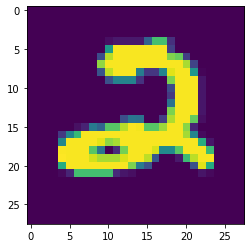

In [146]:
import matplotlib.pyplot as plt
plt.imshow(Tdata_test[0][0][0])


In [14]:
'''Pour utiliser un modèle une fois qu'il est tester... Comment on le fait proprement ? 
Parce que là j'ai l'impression d'être obliger d'uitliser le dataLoader avec des batch de 1 c'est bizarre'''
test = DataLoader(Tdata_val,1,shuffle=True)
#on load le modèle
device = 'cpu'
model = MyCNN().to(device)
load_model("models/1stConv-Fri Dec 23 01:25:40 2022", model)
model_test(model, test)


'96.5% accuracy over 4200 predictions'

## 2/ Optimisation d'un SVM

Cette section à pour but de mettre en pratique la méthode de GridSearch. 

In [61]:
#importation packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
from matplotlib import pyplot as plt



In [112]:
#transformations des données en x et y
def data_transform(data):
    y = data['label'].values
    x = data.drop('label', axis=1).values
    return x,y

x_train, y_train = data_transform(data_train)
x_test, y_test = data_transform(data_val)

In [ ]:
'''on teste combien il faut d'image pour bien construire un SVM'''
list_acc = []
list_nb_data = []
for i in range (100,1000,50):
    xtrain = x_train[:i,:]
    nb_data = xtrain.shape[0]
    print(nb_data)
    ytrain = y_train[:i]
    xtest = x_test[:,:]
    classif = svm.SVC()
    classif.fit(xtrain, ytrain)
    ypred = classif.predict(x_test)
    list_nb_data.append(nb_data)
    list_acc.append(accuracy_score(y_test, ypred))
    print(accuracy_score(y_test, ypred))

plt.plot(list_nb_data, list_acc)

In [130]:
'''Ayant des ressources de calcul limitées, on ne peut pas tester avec un grand nombre d'image...
attention car plus le modèle est grand plus il faut de données pour bien l'entrainer
'''
x_train = x_train[:,:]
y_train = y_train[:]
x_test = x_test[:,:]

### a/ Premier SVM 


0.9121428571428571


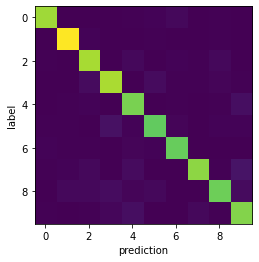

In [131]:
classif = svm.SVC()

# on fit le model à x_triain et y_train
classif.fit(x_train, y_train)

# on prédit les valeurs de y_test
y_pred = classif.predict(x_test)

# on calcule le score de précision multilabel
print(accuracy_score(y_test, y_pred))



from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
#affichage matrice avec pyplot
plt.xlabel('prediction')
plt.ylabel('label')
# à rajouter le nombre d'image dans chaque case de la matrice
plt.imshow(confusion)

### b/ Optimisation SVM 

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid


### MISE EN PLACE DE LA CHAINE ###
classif = svm.SVC()

# liste de tuples: titre + objet 
#pipe = Pipeline([('selvar',selector),('classif',classif)])


grid = [
    #{"kernel": ["sigmoid"], "C": [0.1, 0.5, 1, 2, 5]},
    {"kernel": ["poly"], "degree": [2, 3, 4, 5, 6,10], "C": [0.1, 0.5, 1, 2, 5]},
    #{"kernel": ["rbf"],"gamma": [0.1, 0.5, 1, 2, 5],  },
    {"kernel": ["linear"]},
]

# param_grid = list(ParameterGrid(grid))
# print(len(param_grid))

search = GridSearchCV(classif, grid, n_jobs=2, verbose=0)
search.fit(x_train, y_train)


GridSearchCV(estimator=SVC(), n_jobs=2,
             param_grid=[{'C': [0.1, 0.5, 1, 2, 5],
                          'degree': [2, 3, 4, 5, 6, 10], 'kernel': ['poly']},
                         {'kernel': ['linear']}])

In [135]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
print(search.cv_results_['mean_test_score'])

Best parameter (CV score=0.904):
{'C': 5, 'degree': 2, 'kernel': 'poly'}
[0.77  0.692 0.565 0.484 0.418 0.298 0.887 0.837 0.75  0.674 0.583 0.383
 0.897 0.864 0.788 0.714 0.632 0.408 0.903 0.878 0.811 0.734 0.669 0.441
 0.904 0.887 0.832 0.757 0.693 0.471 0.88 ]


### c/ méthode d'ensemble 

In [115]:
#on load le meilleur des modèles que l'on ait pu entrainer en faisant notre GridSearch.
file = '1stConv-Fri Dec 23 01:25:40 2022'
model = MyCNN()
load_model('models/' + file, model) 
